In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata

In [3]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [65]:
# read in CellRanger output data

folders = ["CID005217-1", "CID005221-1", "CID006493-1", "CID006515-1", "CID007664-1", "CID007827-1", "CID008474-1"]
adata_list = []

# read sample
for sample in folders:
    
        #sample = folders[0]
        path = 'C:/Users/saman/00_Bachelorarbeit/Bachelor/data/' + sample + '/filtered/' # TODO: change to universal path here
        adata = sc.read_mtx(
                filename= (path + 'matrix.mtx'),  # the .mtx file 
        )
        adata = adata.transpose()

        # obs = single cells and their barcodes (2312)
        # var = genes and their annotations (33808)

        adata.obs['sampleID'] = sample
        adata.obs['barcode'] = pd.read_csv((path + 'barcodes.tsv'), delimiter='\t', names=['barcode']).values
        adata.var = pd.read_csv((path + 'features.tsv'), delimiter='\t', names=['gene_ids', 'index', 'feature_types'], index_col='index')
        adata.var_names_make_unique()
        adata.obs.index = adata.obs[['sampleID', 'barcode']].agg('-'.join, axis=1)

        adata_list.append(adata)
        print(sample + " done")


CID005217-1 done
CID005221-1 done
CID006493-1 done
CID006515-1 done
CID007664-1 done
CID007827-1 done
CID008474-1 done


In [69]:
adata_list

[AnnData object with n_obs × n_vars = 2312 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 10359 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2452 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 1695 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 2273 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 949 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types',
 AnnData object with n_obs × n_vars = 3253 × 33808
     obs: 'sampleID', 'barcode'
     var: 'gene_ids', 'feature_types']

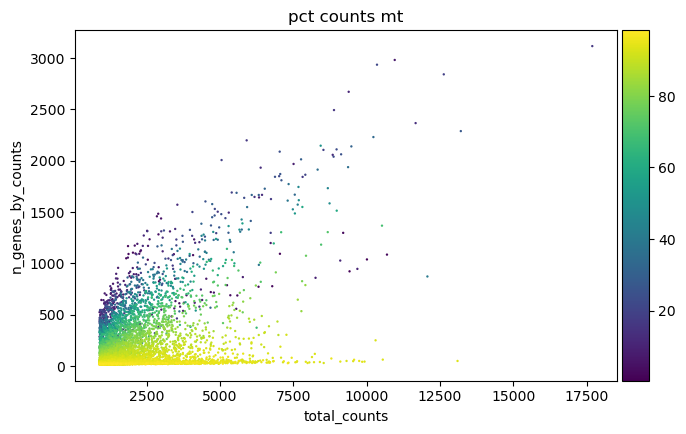

In [73]:
# mitochondrial genes
adata_list[1].var["mt"] = adata_list[1].var_names.str.startswith("MT-")
# ribosomal genes
adata_list[1].var["ribo"] = adata_list[1].var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_list[1].var["hb"] = adata_list[1].var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(adata_list[1], qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) #TODO: do we want log1p here?
sc.pl.scatter(adata_list[1], "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## SoupX 

In [7]:
# adata_pp = adata.copy()
# sc.pp.normalize_per_cell(adata_pp)
# sc.pp.log1p(adata_pp)

# sc.pp.pca(adata_pp)
# sc.pp.neighbors(adata_pp)
# sc.tl.leiden(adata_pp, key_added="soupx_groups")

# # Preprocess variables for SoupX
# soupx_groups = adata_pp.obs["soupx_groups"]


# del adata_pp


# cells = adata.obs_names
# genes = adata.var_names
# data = adata.X.T


# raw_path = '../data/qc_data/' + sample + '/Gene/raw'
# adata_raw = sc.read_10x_mtx(
#     path,  # the directory with the `.mtx` file
#     var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
#     cache=True) 

# adata_raw.var_names_make_unique()
# data_tod = adata_raw.X.T

In [8]:
# do SoupX ambient RNA removal here

## Doublet Detection

In [4]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [5]:
for sample in range(len(adata_list)):
    data_mat = adata_list[sample].X.T
    %R -i data_mat
    %R set.seed(123)
    %R sce = scDblFinder(SingleCellExperiment(list(counts = data_mat), ))
    %R doublet_score = sce$scDblFinder.score
    doublet_score = ro.globalenv['doublet_score']
    #print(doublet_score)
    adata_list[sample].obs['doublet_score'] = doublet_score

adata_list[0].obs.columns

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\anndata2ri\r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not

Index(['sampleID', 'barcode', 'doublet_score'], dtype='object')

## Calculation of QC metrics per sample

In [6]:
# outlier threshold definition
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    lower = np.median(M) - nmads * (M - M.mean()).abs().mean()
    upper = np.median(M) + nmads * (M - M.mean()).abs().mean()
    outlier = (M < lower) | (upper < M)
    return outlier, lower, upper


def all_qc_metrics(adata):

    metrics = {}
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

    # calculate QC metrics now

    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) #TODO: do we want log1p here?

# TODO: PLOTS FOR EACH SAMPLE BEFORE CORRECTING QC !!!
# TODO: remove high value outliers? 0.995 upper percentile
    
    # filter outliers 
    tc_outliers, metrics['tc_lower'], metrics['tc_upper'] = is_outlier(adata, "log1p_total_counts", 5)
    ng_outliers, metrics['ng_lower'], metrics['ng_upper'] = is_outlier(adata, "log1p_n_genes_by_counts", 5)
    top20_outliers, metrics['top20_lower'], metrics['top20_upper'] = is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    adata.obs["outlier"] = (tc_outliers | ng_outliers | top20_outliers)
    
    temp_cell = 0
    if (len(adata.obs.outlier.value_counts()) > 1):
        temp_cell = adata.obs.outlier.value_counts()[1]
    metrics['n_cell_outlier'] = temp_cell

    # filter out high mitochondrial percent cells
    mt_outlier, metrics['mt_lower'], metrics['mt_upper'] = is_outlier(adata, "pct_counts_mt", 3) 
    adata.obs["mt_outlier"] = mt_outlier | ( adata.obs["pct_counts_mt"] > 25) # adjusable value, 25 is permissable

    temp_mt = 0
    if (len(adata.obs.mt_outlier.value_counts()) > 1):
        temp_mt = adata.obs.mt_outlier.value_counts()[1]
    metrics['n_mt_outliers'] = temp_mt

    # summary of removed cells
    metrics['n_cells_before'] = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    metrics['n_cells_after'] = adata.n_obs

    # filter out low count genes
    metrics['n_genes_before'] = adata.n_vars
    # Min 20 cells - filters out 0 count genes
    sc.pp.filter_genes(adata, min_cells=20)
    metrics['n_genes_after'] = adata.n_vars

    return adata, metrics

In [7]:
list_metrics = []
adatas_qced = []

for sample in adata_list:
    adata, metric = all_qc_metrics(sample)
    list_metrics.append(list(pd.Series(metric.values())))
    adatas_qced.append(adata)

In [8]:
df_metrics = pd.DataFrame(data = list_metrics, columns = ["tc_lower", "tc_upper", "ng_lower", "ng_upper", "top20_lower", "top20_upper", "n_cell_outlier", "mt_lower", "mt_upper", "n_mt_outliers",
    "n_cells_before", "n_cells_after", "n_genes_before", "n_genes_after"], index=folders)

df_metrics

# LOOK INTO SAMPLE 5221

tc_lower   tc_upper  ng_lower   ng_upper  top20_lower  \
CID005217-1  6.614544  11.930395  5.153028  10.645279   -39.918747   
CID005221-1  5.376746   9.194267 -1.273096   8.325817    48.173741   
CID006493-1  6.497736  10.489908  3.479385  11.082009   -93.935042   
CID006515-1  6.067164  11.687042  5.648118   9.682451   -41.550147   
CID007664-1  6.560970  11.557833  4.666738  10.319897   -44.704622   
CID007827-1  6.957418  12.123309  5.132477  10.394416   -62.583230   
CID008474-1  7.345757  11.812387  5.756858  10.314995   -54.654893   

             top20_upper  n_cell_outlier   mt_lower    mt_upper  \
CID005217-1   130.192890            45.0 -14.458876   91.659132   
CID005221-1   150.224428           422.0  54.580342  131.275172   
CID006493-1   152.512547            28.0 -69.821949   96.777821   
CID006515-1    89.571512            24.0 -30.417998   52.925185   
CID007664-1   149.345590            40.0 -47.412933   82.189301   
CID007827-1   145.885736             7.0 -37.027208   63.453943   
CID008474-1   121.473950             5.0 -21.757519   56.526844   

             n_mt_outliers  n_cells_before  n_cells_after  n_genes_before  \
CID005217-1          477.0          2312.0          477.0         33808.0   
CID005221-1            0.0         10359.0            0.0         33808.0   
CID006493-1          873.0          2452.0         1561.0         33808.0   
CID006515-1          437.0          1695.0         1258.0         33808.0   
CID007664-1          832.0          2273.0         1441.0         33808.0   
CID007827-1          269.0           949.0          680.0         33808.0   
CID008474-1         1029.0          3253.0         2224.0         33808.0   

             n_genes_after  
CID005217-1        11669.0  
CID005221-1            0.0  
CID006493-1        13328.0  
CID006515-1        13204.0  
CID007664-1        13546.0  
CID007827-1        12708.0  
CID008474-1        14947.0

In [9]:
adatas_qced.pop(1) # remove weird 5221 sample (for now)
adatas_qced

[AnnData object with n_obs × n_vars = 477 × 11669
     obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
     var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells',
 AnnData object with n_obs × n_vars = 1561 × 13328
     obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_coun

In [10]:
# concat all sample anndata objects into one
adata = anndata.concat(adatas_qced)
adata

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'

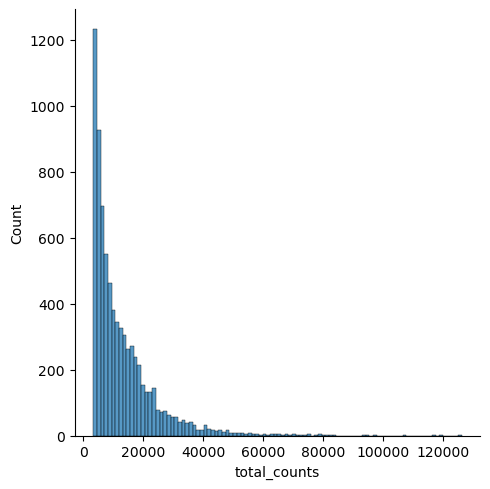

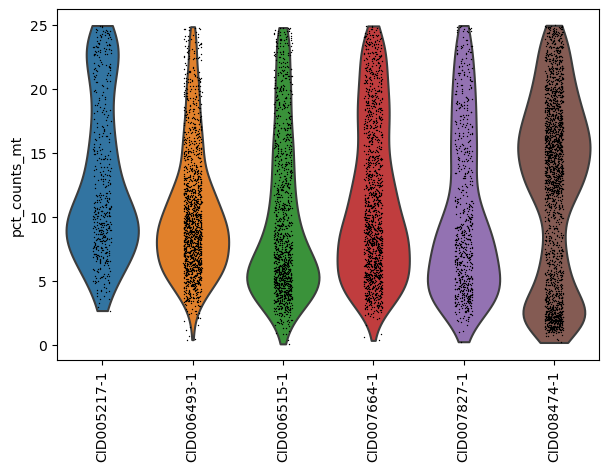

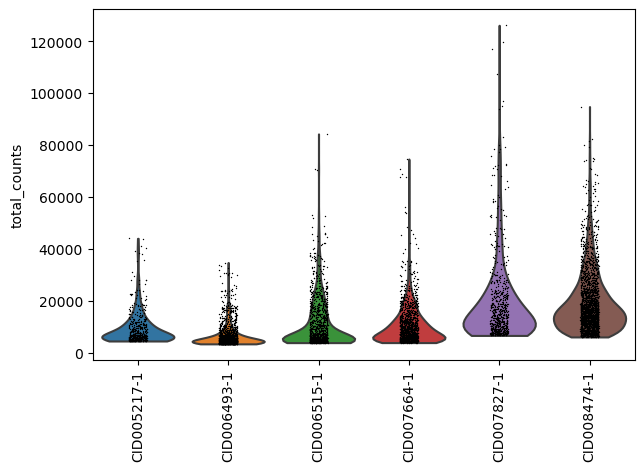

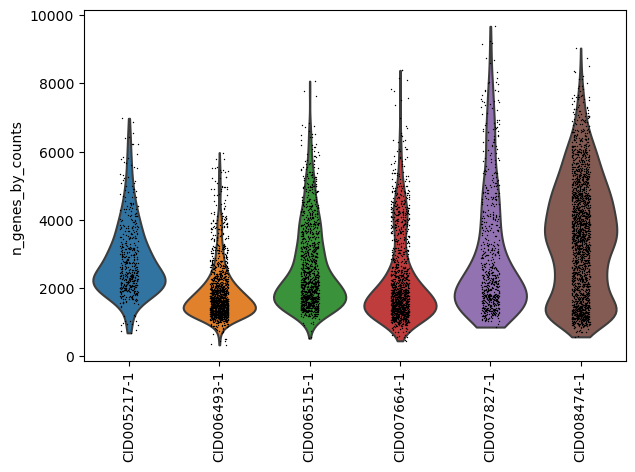

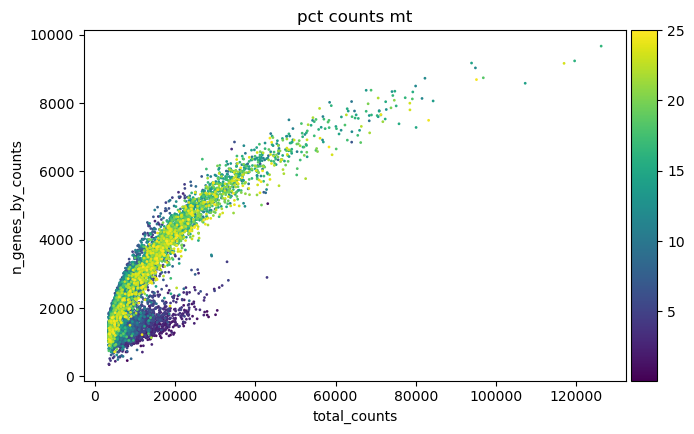

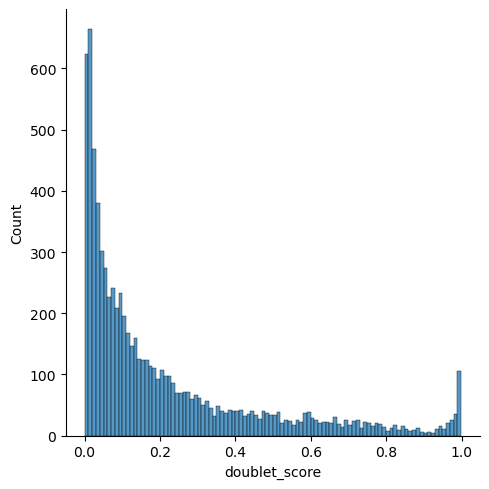

In [11]:
# plotting QC metrics AFTER QC CORRECTION ON EACH SAMPLE INDIVIDUALLY

p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt", groupby= "sampleID", rotation=90)
p3 = sc.pl.violin(adata, "total_counts", groupby= "sampleID", rotation=90)
p4 = sc.pl.violin(adata, "n_genes_by_counts", groupby= "sampleID", rotation=90)
p5 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p6 = sns.displot(adata.obs["doublet_score"], bins=100, kde=False)

In [12]:
# write raw data to file for scvi integration

adata.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_raw.h5ad"
)

## TC Normalization

In [16]:
# save unnormalized data to inspect effect and save raw data
adata_notnorm = adata.copy()

In [17]:
# normalize and log1p fitting

# proportional fitting to mean of cell depth
sc.pp.normalize_total(adata, target_sum=None)
# log1p transform
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    uns: 'sampleID_colors', 'log1p'

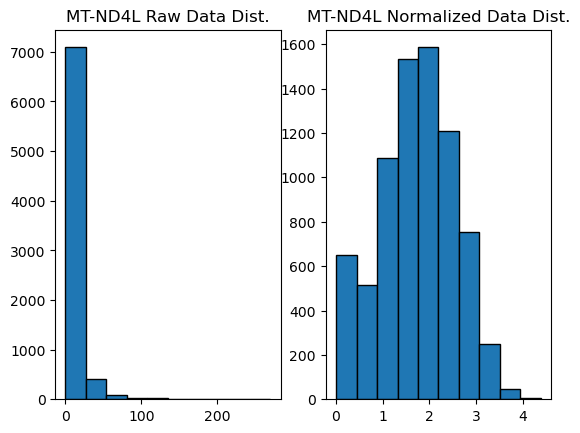

In [18]:
# show effect of normalization
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(adata_notnorm.to_df()["MT-ND4L"], edgecolor="black")
ax1.set_title('MT-ND4L Raw Data Dist.')
ax2.hist(adata.to_df()["MT-ND4L"], edgecolor="black")
ax2.set_title('MT-ND4L Normalized Data Dist.')
plt.show()

In [13]:
# read in integrated normalized expression 

adata_int = anndata.read_h5ad("C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_integrated.h5ad")
adata_int

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'integrated'
    obsp: 'connectivities', 'distances'

## Method to run through batch-wise HVGS and dim. reduction automatically

In [19]:
# function to select batch key and perform HVG selection, PCA, and UMAP on this subset

def batch_reduction(adata, batch_key=None):
    temp = adata.copy()
    # HVG selection using inputted batch key
    sc.pp.highly_variable_genes(temp, n_top_genes=2000, batch_key=batch_key, subset=True)

    # dimensionality reduction
    sc.pp.pca(temp, n_comps=50, svd_solver="arpack") #PCA
    sc.pp.neighbors(temp)
    sc.tl.umap(temp) # UMAP

    return temp

In [20]:
adata_new = batch_reduction(adata)
adata_new

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sampleID_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [21]:
adata_sample_batch = batch_reduction(adata, "sampleID")
adata_sample_batch

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarnin

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sampleID_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
# clean up adata_int to only contain normalized integrated matrix
adata_int.X = adata_int.layers['integrated']
del adata_int.layers["integrated"]
adata_int

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [25]:
adata_int_new = batch_reduction(adata_int)
adata_int_new

AnnData object with n_obs × n_vars = 7641 × 2000
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap', 'hvg', 'pca'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


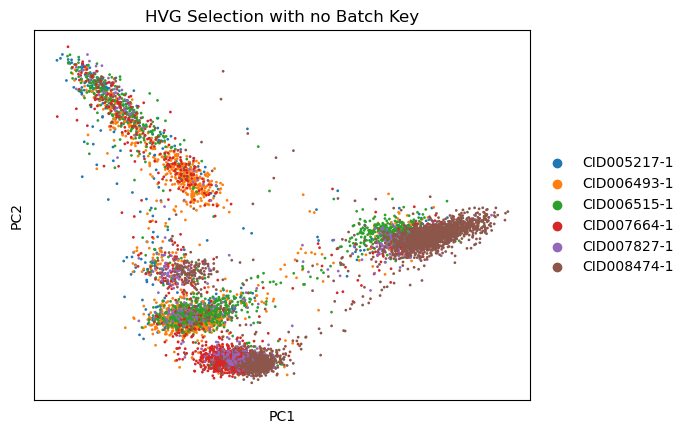

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


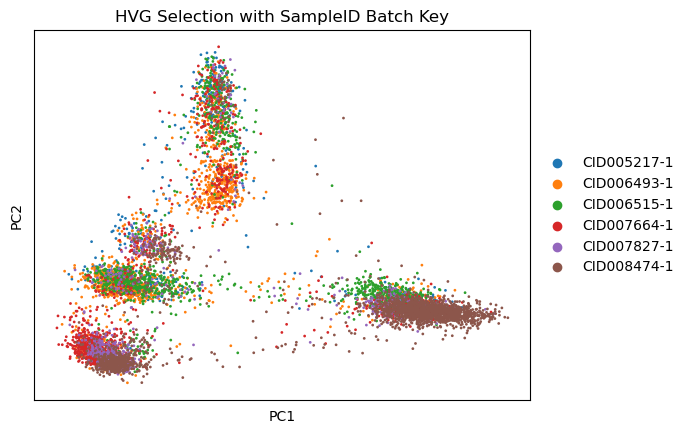

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


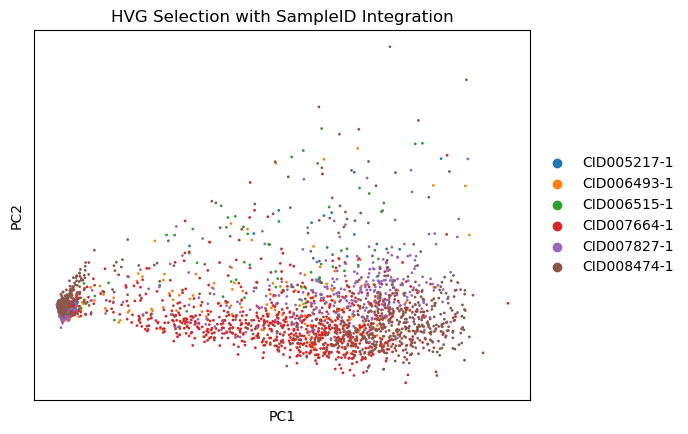

In [27]:
color = "sampleID"

pca1 = sc.pl.pca_scatter(adata_new, color=color, title="HVG Selection with no Batch Key")

pca2 = sc.pl.pca_scatter(adata_sample_batch, color=color, title="HVG Selection with SampleID Batch Key")

pca3 = sc.pl.pca_scatter(adata_int_new, color=color, title="HVG Selection with SampleID Integration")

## UMAPs

In [28]:
# UMAPs
sc.tl.umap(adata_new)

sc.tl.umap(adata_sample_batch)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


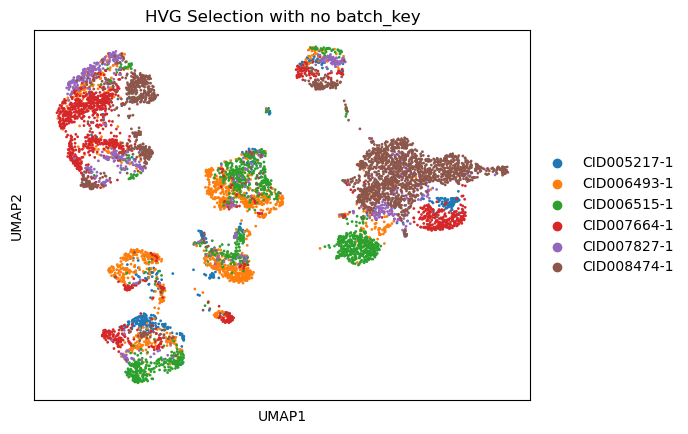

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


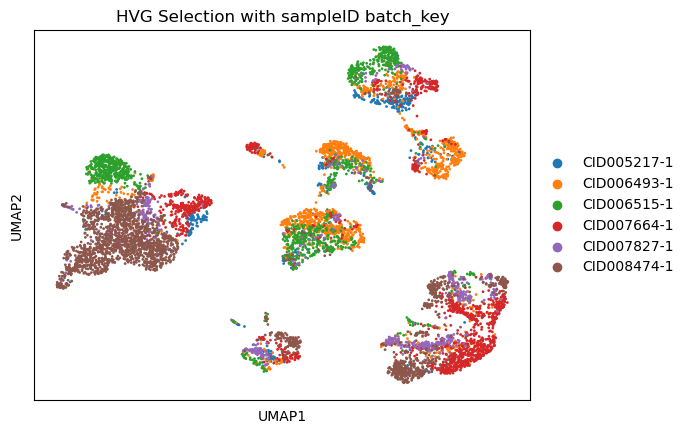

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


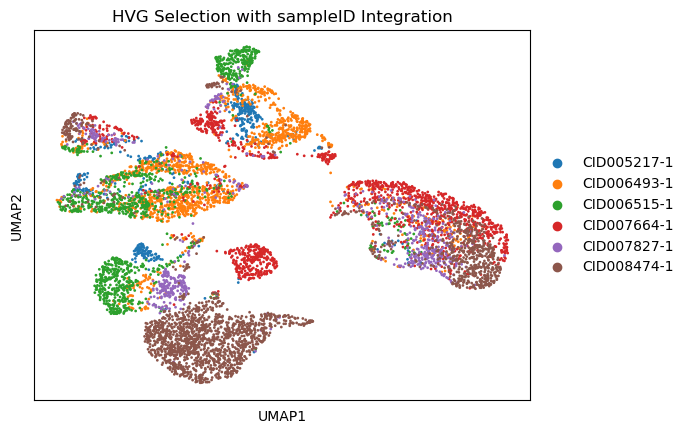

In [29]:
# color by corresponding batch var 

umap1 = sc.pl.umap(adata_new, color=color, title='HVG Selection with no batch_key') 
umap2 = sc.pl.umap(adata_sample_batch, color=color, title='HVG Selection with sampleID batch_key')
umap3 = sc.pl.umap(adata_int_new, color=color, title='HVG Selection with sampleID Integration')

In [28]:
# write data so far to file

#import hdf5plugin

adata_new.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_preprocessed.h5ad"
)

adata_sample_batch.write_h5ad(
    "C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_preprocessed_samplebatch.h5ad"
)

## Coarse Cell Types

In [32]:
# load integrated data

adata = anndata.read_h5ad("C:/Users/saman/00_Bachelorarbeit/Bachelor/data/output/adata_integrated.h5ad")
adata

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'integrated'
    obsp: 'connectivities', 'distances'

In [5]:
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scVI")
sc.tl.umap(adata)

In [6]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


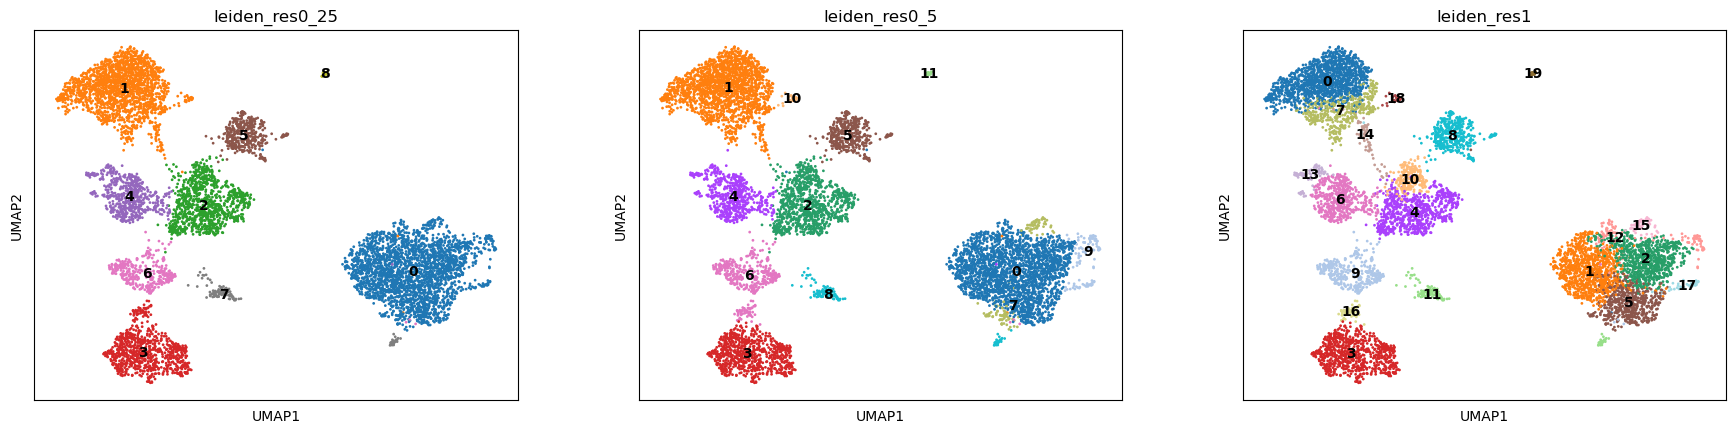

In [7]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [33]:
marker_genes = {
    "CD4 CD8 T Cell": 
    [
        "SELL", "CCR7",
        "ITGAE", "ITGA1", "SPRY1", "IL17A", "CCR6", "CCL20",
        "CXCR5", "BCL6", "PDCD1", "CD40LG",
        "FOXP3", "CTLA4", "IL2RA", "IL10",
        "GZMK", "CRTAM", "EOMES"
    ], 
    "Gamma Delta T Cell": 
    [
        "SELL", "KLRC2", "TRDC", "TRGC1", "KIR2DL4", "CCR7"
        "KLRC2", "TRDC", "TRGC1", "KIR2DL4", 
        "SLC4A10", "TRAV1-2"
    ], 
    "NK T Cell": 
    [
        "FCGR3A", "GNLY", "GZMB", "NKG7",
        "XCL1", "IL2RB", "NCR1", "FCER1G", "NCAM1"
    ], 

    "Dentritic Cell": 
    [
        "CLEC9A", "XCR1", "BATF3", "CADM1", "RAB7B",
        "CLEC10A", "FCER1A", "CD1C",
        "CCR7", "LAMP3",
        "IRF7", "CLEC4C", "JCHAIN", "LILRA4", "GZMB",
        "ITGAX", "IL22RA2", "CD207", "RUNX3"
    ], 
    "Macrophage": 
    [
        "LYVE1", "RNASE1", "FOLR2",
        "MMP9", "PLA2G2D", "ADAMDEC1",
        "TREM2", "ACP5", "CTSD", "CSTB",
        "CD5L", "VCAM1", "CXCL12", "PDK4", "RBP7",
        "CD209"
    ],
    "Monocyte": 
    [
        "IL1B", "EREG", "NAMPT", "PLAUR", "VCAN", "FPR1", "CD3D00E", "MPO", "RETN", "RNASE2", "PCLAF"
    ],

    "Plasma B Cell": 
    [
        "XBP1",
        "IGHM",
        "IGHA1",
        "IGHA2",
        "IGHG3", "IGHG1", "IGHG2", "IGHG4"
    ],
    "B Cell": 
    [
        "SPIB", "TCL1A", "CD3D7",
        "IGLL1", "RAG1", "DNTT", "VPREB3",
        "SELL", "TCL1A", "IGHD",
        "CD27", "TNFSF13B",
        "MKI67", "AICDA",
        "BCL6", "SUGCT"
    ], 

    "Endothelial Cell": 
    [
        "RGCC", "COL4A1", "COL4A2", "IL32", "MCAM", "MYO1B",
        "GJA4", "HEY1", "CXCL12", "SEMA3G", "IGFBP3", "FBLN2", "FBLN5", "ELN",
        "BTNL9", "ALPL",
        "ACKR1", "CCL14", "SELE", "TNFRSF6B",
        "CCL21", "TFF3", "PROX1", "NTS",
        "MKI67", "TOP2A"
    ], 

    "Pericyte": 
    [
        "RERGL", "MUSTN1", "LBH", "NET1", "MAP3K20",
        "COX4I2", "HIGD1B", "RGS5", "NDUFA4L2",
        "GPC3", "COL14A1", "ECRG4", "ID4", "FHL2", "CXCL12"
    ],
    "Fibroblast": 
    [
        "ACTG2", "HHIP", "SOSTDC1", "NPNT",
        "CCL21", "CCL19", "TNFSF13B", "TDO2",
        "CTHRC1", "COL12A1", "COL1A1", "CTSK", "COL5A2",
        "APOD", "PLPP1", "MFAP4", "IFITM1", "RASD1",
        "PI16", "RSPO3", "SFRP1", "TM2A",
        "F3", "PLAT", "HSD17B2", "SOX6",
        "ADAMDEC1", "ADAM28", "CCL11", "CCL8", "CCL13", "CFD",
        "KCNN3", "THBS4", "FNDC1", "PPFIBP1"
    ], 
    
    "Keratinocyte Cells": ["LY6D", "KRT16", "KRT6A", "DSG1", "FDCSP", "ODAM", "CXCL1", "CLEC2B", "CRNN", "CNFN", "TGM3", "SPRR3", "SBSN", "CRCT1", "UPK2", "GPR160", "SCGB1A1", "KRT6C"],
    "Epithelial Cells": ["PCNA", "DUT", "MCM3", "HELLS", "SLBP", "CCNB1", "CENPF", "CDC20", "CKS2", "MKI67", "TK1", "KRT15", 
                         "CXCL14", "COL17A1", "PCLAF", "MUC2", "TFF3", "FCGBP", "ZG16", "TOP2A", "MUC17", "TFF1"],
    "Gland Cells": ["LPO", "RARRES1", "ALDH1A3", "CCL28", "TFF3", "MUC5B", "BPIFB2", "AQP5", "PRR4", "CD74", "MUC6", "BPIFB1"],
    "Enteroendocrine Cells": ["HOPX", "CRYBA2", "GCG", "MLN", "GLS", "GAST", "SCGB2A1", "CLTRN", "CES1", "PAX6",
                            "SST", "GHRL", "GC", "ACSL1", "S100A1", "CHGA", "PCSK1N", "SCT", "SCGN", "NEUROD1", "SOX4"],
    "Enterocyte Cells": ["FABP2", "ALDOB", "APOA1", "FABP1", "APOA4", "PRAP1", "PCK1", "RBP2", "SI", "BEST4", "CA7", "OTOP2", "CFTR"],
    "Tuft Cells": ["SH2D6", "LRMP", "MATK", "FYB1", "HPGDS", "POU2F3", "TRPM5"],
    "Goblet Cells": ["GAU1", "MUC2", "TFF3", "FCGBP", "ZG16", "OLFM4", "MKI67", "TOP2A"],
    "Colonocyte Cells": ["SLC26A3", "AQP8", "CEACAM7", "CA1", "GPT", "BEST4", "CA7", "OTOP2"],

}

endo = ["Keratinocyte Cells", "Epithelial Cells", "Gland Cells", "Enteroendocrine Cells", "Enterocyte Cells", "Tuft Cells", "Goblet Cells", "Colonocyte Cells"]

In [34]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [35]:
adata.layers["counts"] = adata.X
adata.X = adata.layers['integrated']

In [37]:
sc.pp.highly_variable_genes(adata)
adata.var

highly_variable     means  dispersions  dispersions_norm
index                                                               
AL669831.5            False  0.000006   -12.140733         -1.000625
NOC2L                 False  0.000039   -11.691569         -0.663507
AL645608.7            False  0.000010   -10.706135          0.076106
HES4                  False  0.000093    -8.524400          1.713597
ISG15                 False  0.000178    -7.696461          2.335003
...                     ...       ...          ...               ...
MT-ND4L               False  0.000726    -7.735855          2.305436
MT-ND4                False  0.009306    -5.825378         -1.130872
MT-ND5                False  0.002868    -6.757862          0.447665
MT-ND6                False  0.000202    -8.310297          1.874291
MT-CYB                False  0.011612    -5.679211          1.000000

[10962 rows x 4 columns]

In [38]:
sc.tl.pca(adata, use_highly_variable=True)

In [39]:
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scVI")
sc.tl.umap(adata)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


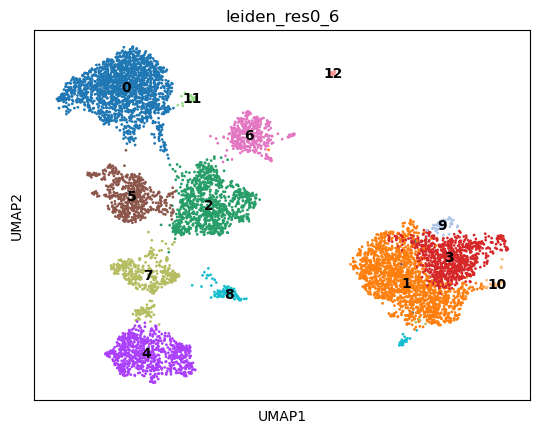

In [40]:
sc.tl.leiden(adata, key_added="leiden_res0_6", resolution=0.6)
sc.pl.umap(
    adata,
    color=["leiden_res0_6"],
    legend_loc="on data",
)

ENTEROENDOCRINE CELLS:


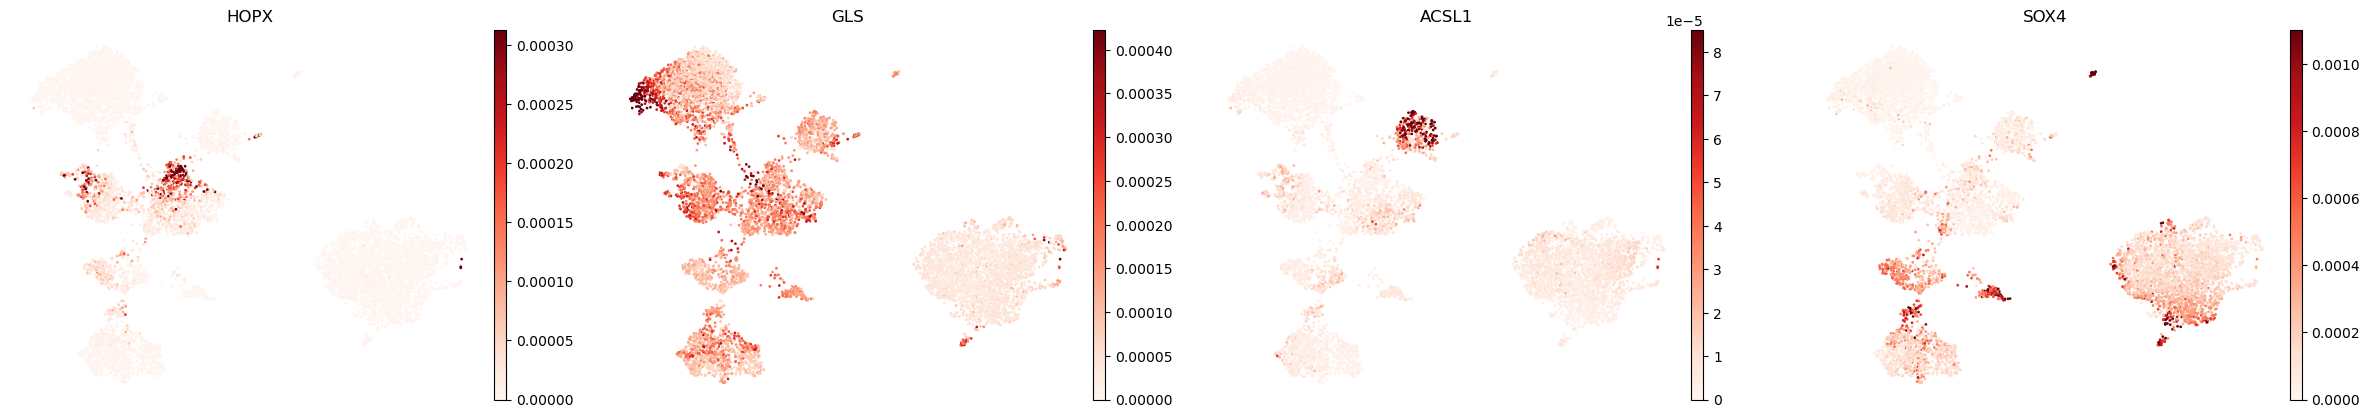

In [30]:
subtypes = ["Enteroendocrine Cells"]
for ct in subtypes:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  
    )
    print("\n\n\n")  # print white space for legibility

In [41]:
endo_markers = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes_in_data.items()
    if ct in endo
}

other_markers = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes_in_data.items()
    if ct not in endo
}

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


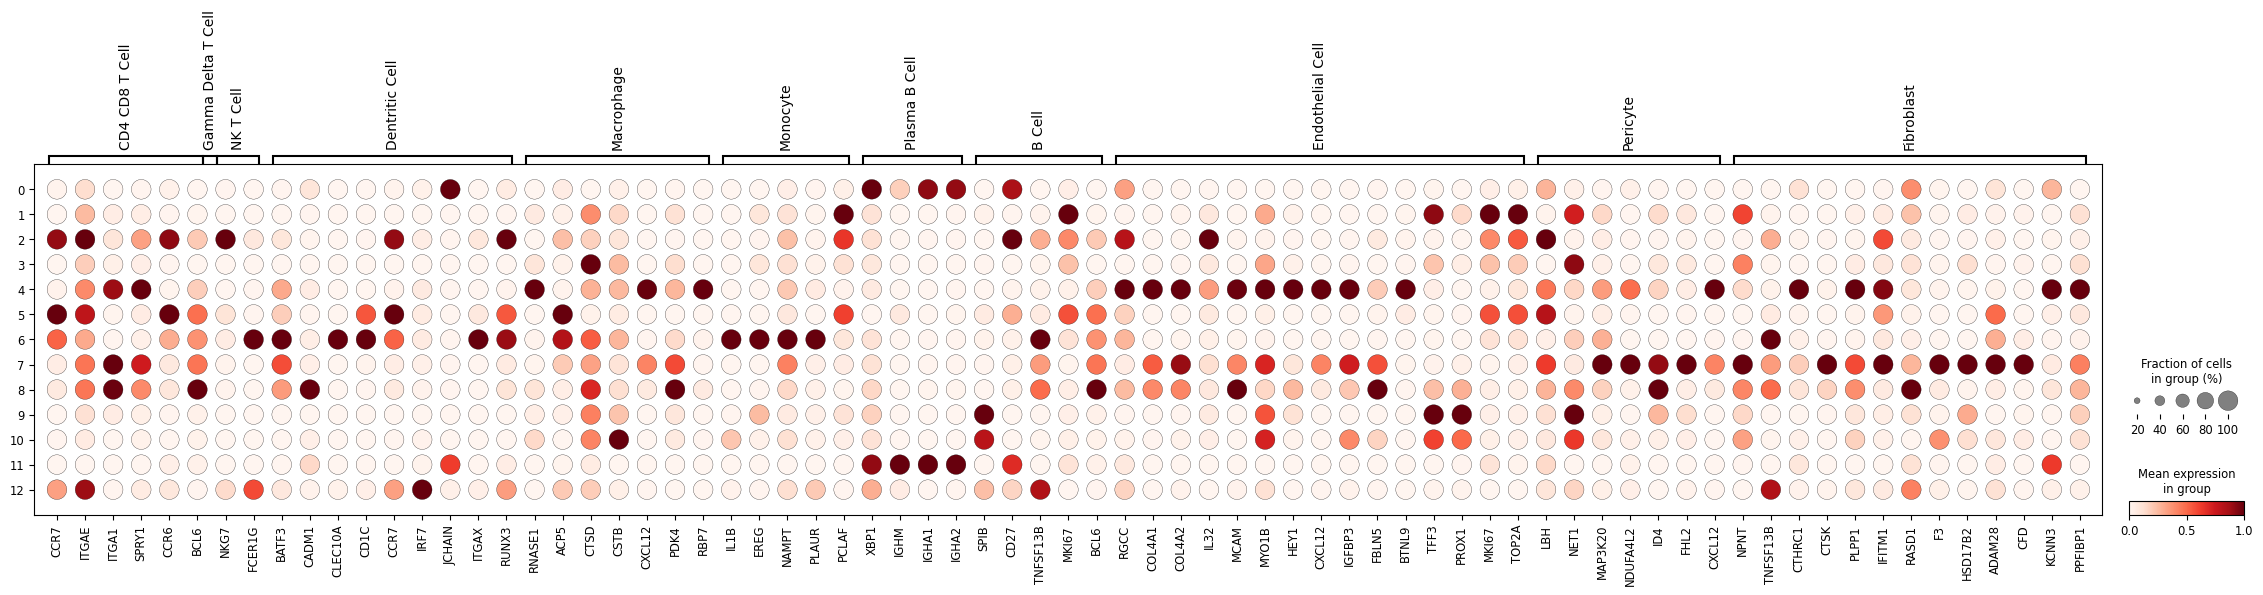

In [42]:
sc.pl.dotplot(
    adata,
    groupby="leiden_res0_6",
    var_names=other_markers,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


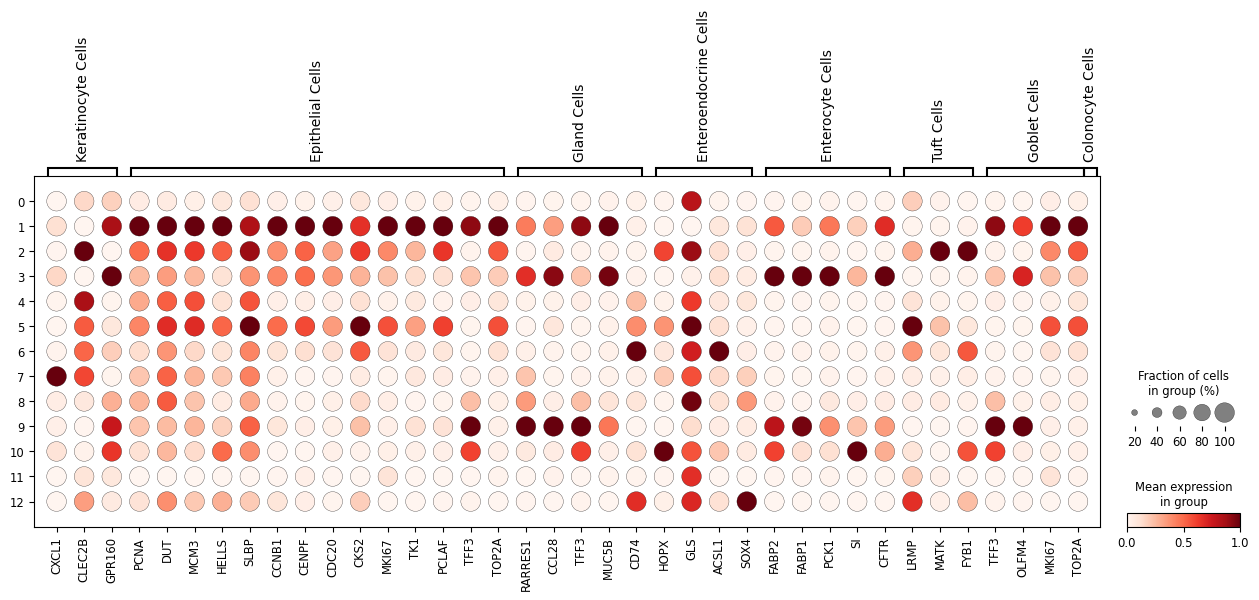

In [28]:
sc.pl.dotplot(
    adata,
    groupby="leiden_res0_6",
    var_names=endo_markers,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [31]:
cl_annotation = {
    "0": "",
    "1": "Epithelial Cells / Goblet Cells",
    "2": "tuft Cells",
    "3": "Enterocyte Cells", 
    "4": "Endothelial Cell / Macrophage",
    "5": "CD4 CD8 T Cell", 
    "6": "Monocyte / Dentritic Cell",
    "7": "Pericyte / Fibroblast / Keratinocyte Cells", 
    "8": "IDK",
    "9": "Gland Cells",
    "10": "IDK",
    "11": "Plasma B Cell",
    "12": "Enteroendocrine Cells"
    
}

In [45]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden_res0_6", method="wilcoxon", key_added="dea_leiden0_6"
)

c:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


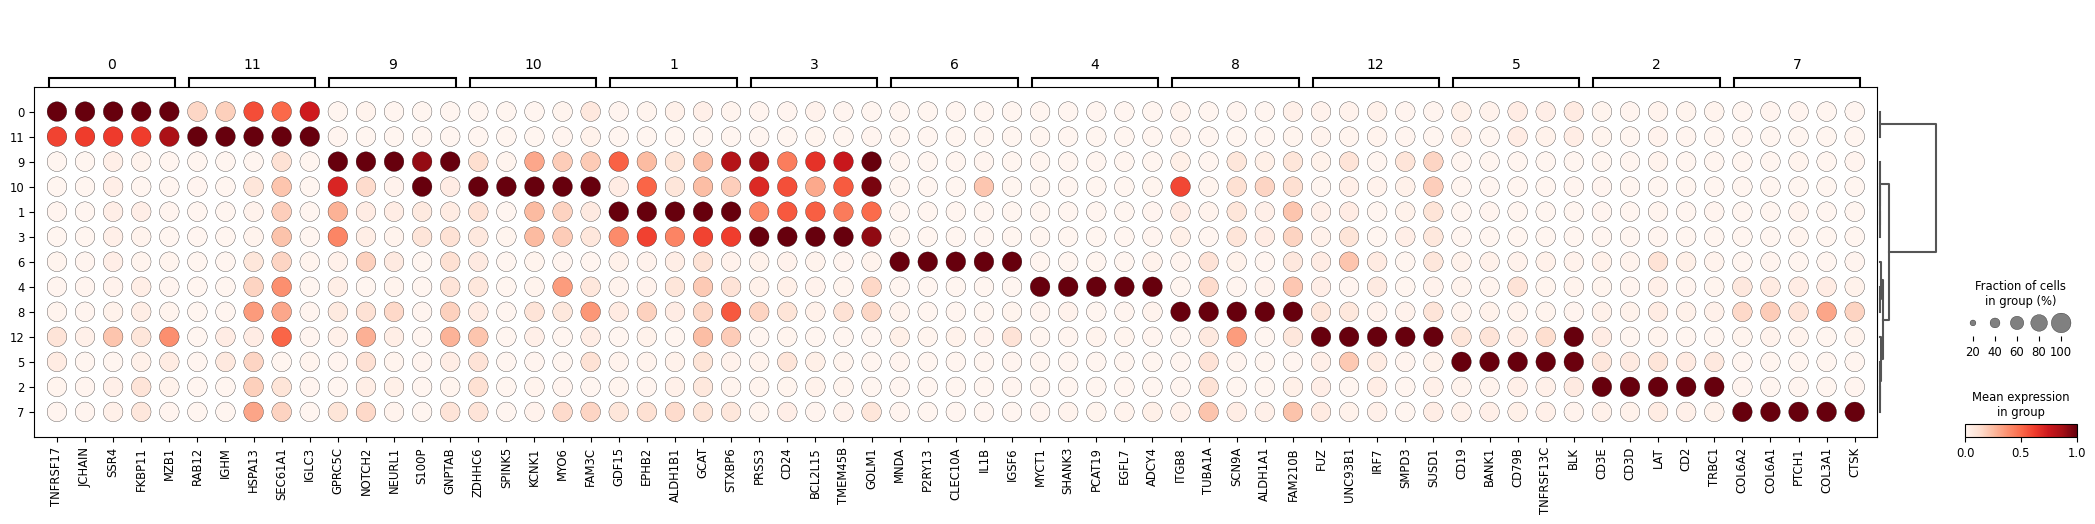

In [46]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res0_6", standard_scale="var", n_genes=5, key="dea_leiden0_6"
)

In [52]:
import celltypist
from celltypist import models

In [50]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()
adata_celltypist

AnnData object with n_obs × n_vars = 7641 × 10962
    obs: 'sampleID', 'barcode', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'sampleID_colors', 'umap', 'hvg', 'pca', 'leiden', 'leiden_res0_6_colors', 'dea_leiden_0_6', 'dea_leiden0_6', 'dendrogram_leiden_res0_6', 'log1p'
    obsm: 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'integrated', 'counts'
    obsp: 'connectivities', 'distances'

In [53]:
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in C:\Users\saman\.celltypist\data\models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [54]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

In [55]:
model_high.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [56]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

🔬 Input data has 7641 cells and 10962 genes
🔗 Matching reference genes in the model
🧬 3868 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [57]:
predictions_high_adata = predictions_high.to_adata()

In [58]:
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]

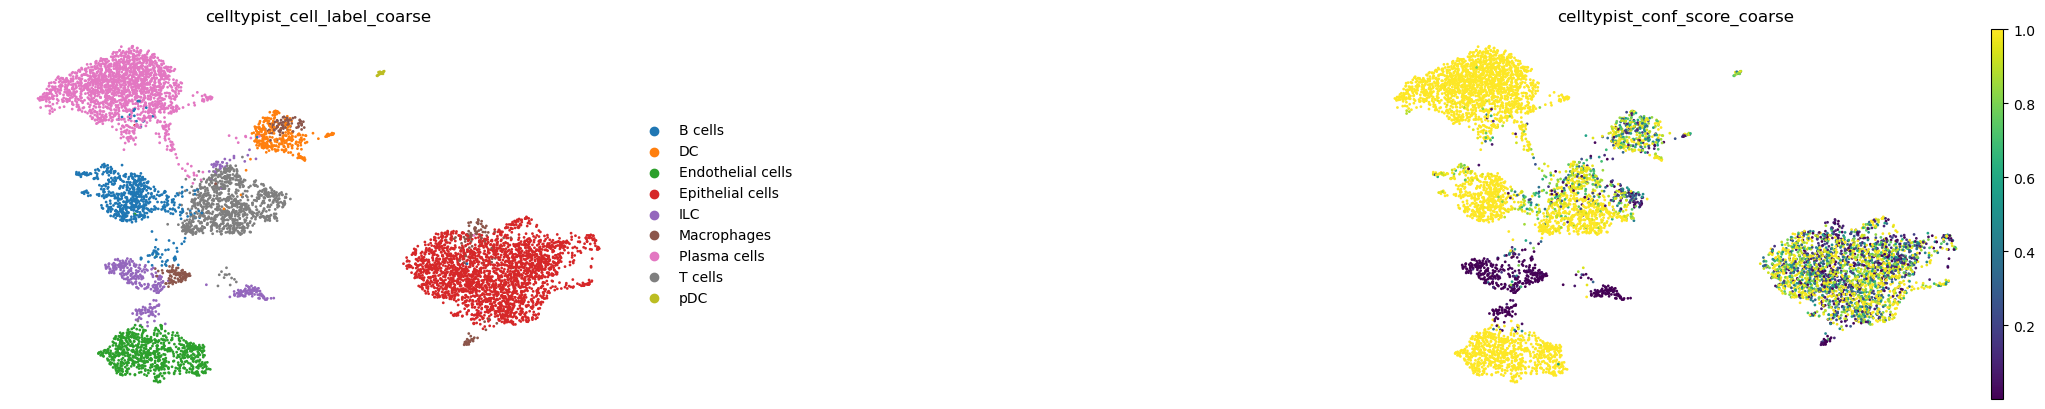

In [59]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

... storing 'manual_celltype_annotation' as categorical


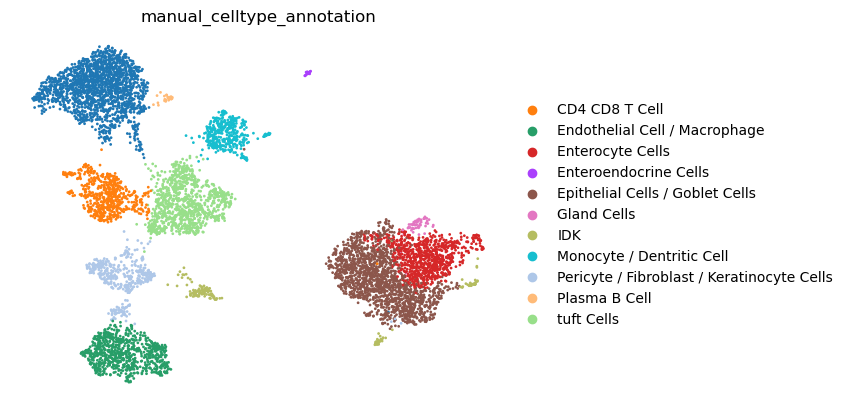

In [61]:
adata.obs["manual_celltype_annotation"] = adata.obs.leiden_res0_6.map(cl_annotation)

sc.pl.umap(
    adata,
    color=["manual_celltype_annotation"],
    frameon=False,
)